# **2017 Superstore K-Means clustering**
##### **Author** 
Jessica Chew
##### **Analysis objective** 
Create an Recency, Frequency, Monetization (RFM) segmentation framework for the 2017 Superstore customers.
##### **Analysis methodology** 
Scale featureset with a logarithmic 10 treatment and standard scaler. Use the three features as inputs into the k-Means model
##### **Analysis date range** 
2017

##### **Packages used**

In [26]:
#if first time then !pip install pandas-gbq
from __future__ import division
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.cluster import KMeans
import pylab as plt 
from google.cloud import bigquery
%matplotlib inline
# import plotly.plotly as py
# import plotly.offline as pyoff
# import plotly.graph_objs as go

from IPython.display import HTML
import base64  
import pandas_gbq
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

##### **Pipe in BigQuery data** (Base query in Appendix 1)

In [2]:
## Feature set: 2017 modeled RFM data at the customer level

client = bigquery.Client(location="US")
print("Client creating using default project: {}".format(client.project))
df = "SELECT * FROM `analytics-pro-merch-strat-thd.Z_JCHEW.superstore_RFM_model_base`"
query_job = client.query(
    df,
    # Location must match that of the dataset(s) referenced in the query.
    location="US",
)  # API request - starts the query

df = query_job.to_dataframe()
df

/opt/conda/lib/python3.7/site-packages/google/auth/_default.py:69: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. We recommend you rerun `gcloud auth application-default login` and make sure a quota project is added. Or you can use service accounts instead. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)
/opt/conda/lib/python3.7/site-packages/google/auth/_default.py:69: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. We recommend you rerun `gcloud auth application-default login` and make sure a quota project is added. Or you can use service accounts instead. For more information about service accounts, see https://clou

Client creating using default project: analytics-pro-merch-strat-thd


,Customer_ID,RECENCY,FREQUENCY,MONETIZATION
0,SM-20905,608,1,1043.041
1,RE-19405,1099,1,48.360
2,JR-15700,70,1,863.880
3,MG-18205,266,1,16.739
4,LD-16855,554,1,5.304
...,...,...,...,...
788,TB-21400,204,7,9133.990
789,BC-11125,204,9,2933.676
790,DW-13480,219,5,5271.628
791,DN-13690,219,7,2139.790


In [3]:
df.shape

(793, 4)

In [4]:
#Check number of nulls per column in dataframe
df_nulls = df.isnull().sum(axis = 0)
df_nulls

Customer_ID     0
RECENCY         0
FREQUENCY       0
MONETIZATION    0
dtype: int64

##### **Standardization step 1 of 2 - apply the log of 10 to all features**

In [8]:
#step 1 of 2 standardisation
df['LOG_RECENCY']=np.log10(df['RECENCY'])
df['LOG_FREQUENCY']=np.log10(df['FREQUENCY'])
df['LOG_MONETIZATION']=np.log10(df['MONETIZATION'])
df

,Customer_ID,RECENCY,FREQUENCY,MONETIZATION,LOG_RECENCY,LOG_FREQUENCY,LOG_MONETIZATION
0,SM-20905,608,1,1043.041,2.783904,0.000000,3.018301
1,RE-19405,1099,1,48.360,3.040998,0.000000,1.684486
2,JR-15700,70,1,863.880,1.845098,0.000000,2.936453
3,MG-18205,266,1,16.739,2.424882,0.000000,1.223730
4,LD-16855,554,1,5.304,2.743510,0.000000,0.724604
...,...,...,...,...,...,...,...
788,TB-21400,204,7,9133.990,2.309630,0.845098,3.960661
789,BC-11125,204,9,2933.676,2.309630,0.954243,3.467412
790,DW-13480,219,5,5271.628,2.340444,0.698970,3.721945
791,DN-13690,219,7,2139.790,2.340444,0.845098,3.330371


##### **Create a separate dataframe of only the three input features treated with log10 in preparation for pairplot visualisation**

In [10]:
df_input_features = df[['LOG_RECENCY','LOG_FREQUENCY','LOG_MONETIZATION']] ##toggle on and off with above and below lines
df_input_features.head()

,LOG_RECENCY,LOG_FREQUENCY,LOG_MONETIZATION
0,2.783904,0.0,3.018301
1,3.040998,0.0,1.684486
2,1.845098,0.0,2.936453
3,2.424882,0.0,1.223730
4,2.743510,0.0,0.724604


In [35]:
df_input_features.shape

(793, 3)

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:1659: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using silverman for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:1659: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using silverman for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:1659: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using silverman for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


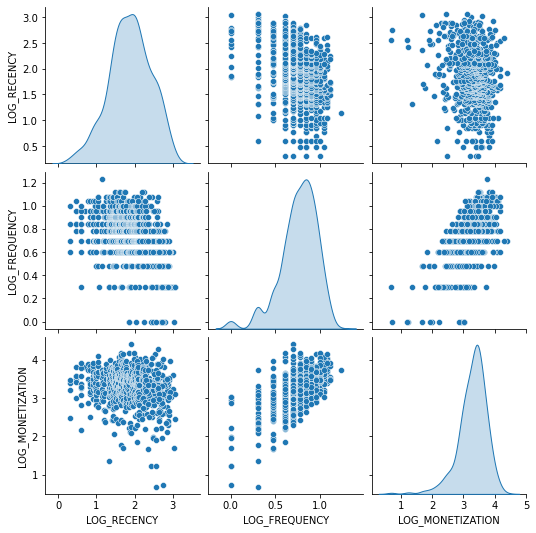

In [11]:
# Plot to view the distribution 
sns.pairplot(df_input_features,  diag_kind='kde', diag_kws={'bw': 'silverman'})

The LOG_RECENCY feature's distribution is relatively normal. LOG_MONETIZATION is left skewed. Future iterations with alternative segmentation models such as DB Scan are warranted. 

##### **Standardization part 2 of 2**

In [15]:
###Standardize the log10 of features part 2 of 2
scaler = StandardScaler()
scaler.fit(df_input_features)
df_input_features_transformed = scaler.transform(df_input_features)
df_input_features_transformed = pd.DataFrame(data=df_input_features_transformed, index = df_input_features.index, columns = df_input_features.columns)
df_input_features_transformed

,LOG_RECENCY,LOG_FREQUENCY,LOG_MONETIZATION
0,1.668671,-3.692589,-0.577306
1,2.138609,-3.692589,-3.490092
2,-0.047357,-3.692589,-0.756046
3,1.012420,-3.692589,-4.496293
4,1.594836,-3.692589,-5.586285
...,...,...,...
788,0.801754,0.421616,1.480618
789,0.801754,0.952966,0.403462
790,0.858078,-0.289781,0.959311
791,0.858078,0.421616,0.104192


In [18]:
###Begin process to rename the standardized log10 of features with an 's_'
df_input_features_transformed.columns

Index(['LOG_RECENCY', 'LOG_FREQUENCY', 'LOG_MONETIZATION'], dtype='object')

In [19]:
df_input_features_transformed.columns = ['s_LOG_RECENCY', 's_LOG_FREQUENCY', 's_LOG_MONETIZATION']

In [20]:
df_input_features_transformed.head()

,s_LOG_RECENCY,s_LOG_FREQUENCY,s_LOG_MONETIZATION
0,1.668671,-3.692589,-0.577306
1,2.138609,-3.692589,-3.490092
2,-0.047357,-3.692589,-0.756046
3,1.012420,-3.692589,-4.496293
4,1.594836,-3.692589,-5.586285


In [22]:
###Join the standardized log10 of features back to the core featureset. Output will be a table with 15 columns
df_final = pd.concat([df, df_input_features_transformed],axis=1)

In [23]:
df_final

,Customer_ID,RECENCY,FREQUENCY,MONETIZATION,LOG_RECENCY,LOG_FREQUENCY,LOG_MONETIZATION,s_LOG_RECENCY,s_LOG_FREQUENCY,s_LOG_MONETIZATION
0,SM-20905,608,1,1043.041,2.783904,0.000000,3.018301,1.668671,-3.692589,-0.577306
1,RE-19405,1099,1,48.360,3.040998,0.000000,1.684486,2.138609,-3.692589,-3.490092
2,JR-15700,70,1,863.880,1.845098,0.000000,2.936453,-0.047357,-3.692589,-0.756046
3,MG-18205,266,1,16.739,2.424882,0.000000,1.223730,1.012420,-3.692589,-4.496293
4,LD-16855,554,1,5.304,2.743510,0.000000,0.724604,1.594836,-3.692589,-5.586285
...,...,...,...,...,...,...,...,...,...,...
788,TB-21400,204,7,9133.990,2.309630,0.845098,3.960661,0.801754,0.421616,1.480618
789,BC-11125,204,9,2933.676,2.309630,0.954243,3.467412,0.801754,0.952966,0.403462
790,DW-13480,219,5,5271.628,2.340444,0.698970,3.721945,0.858078,-0.289781,0.959311
791,DN-13690,219,7,2139.790,2.340444,0.845098,3.330371,0.858078,0.421616,0.104192


##### **Create an elbow chart of the four features in this model. Optimal k looks to be 4 clusters. The silhouette score gives poorer results. The highest k score is 0.28. Experiment with 4 clusters for now**

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


For n_clusters=2, The Silhouette Coefficient is 0.032119396908432775
For n_clusters=3, The Silhouette Coefficient is 0.003120241822822178


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


For n_clusters=4, The Silhouette Coefficient is -0.04847271683828331
For n_clusters=5, The Silhouette Coefficient is -0.049206723927339234


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


For n_clusters=6, The Silhouette Coefficient is -0.09726358611984941
For n_clusters=7, The Silhouette Coefficient is -0.10258216000248659


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


For n_clusters=8, The Silhouette Coefficient is -0.10224996987301525
For n_clusters=9, The Silhouette Coefficient is -0.09615700530114019
For n_clusters=10, The Silhouette Coefficient is -0.10482637794662042


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


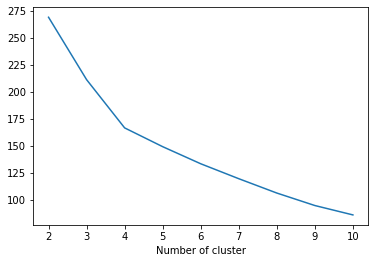

In [37]:
# ###OPTION 1 OF 2 - Elbow and silhouette checks based on log 10 only
# #this is the elbow chart

sse={}
metric = df_final[['LOG_RECENCY','LOG_FREQUENCY','LOG_MONETIZATION']]
#metric = df_final[['s_LOG_RECENCY','s_LOG_FREQUENCY','s_LOG_MONETIZATION']] ##toggle

for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, max_iter=200).fit(metric)
    metric["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
    labels = kmeans.labels_
    sil_coeff = silhouette_score(df_input_features_transformed, labels, metric='euclidean')
    print("For n_clusters={}, The Silhouette Coefficient is {}".format(k, sil_coeff))
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

##### **Run the k-means model**

In [38]:
#Cluster specification
n_clusters = 4

##### **Code block below executes the k-means clustering algorithm to create the recency cluster**

In [39]:
#Execute Cluster
kmeans = KMeans(n_clusters = n_clusters, random_state=2021)
## kmeans.fit(df_final[['LOG_RECENCY','LOG_FREQUENCY','LOG_MONETIZATION']]) ##toggle on and off
kmeans.fit(df_final[['s_LOG_RECENCY','s_LOG_FREQUENCY','s_LOG_MONETIZATION']]) ##toggle on and off
df_final['CLUSTER'] = kmeans.predict(df_final[['s_LOG_RECENCY','s_LOG_FREQUENCY','s_LOG_MONETIZATION']])

#function for ordering cluster numbers
def order_cluster(cluster_field_name, target_field_name,df,ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final


df_final = order_cluster('CLUSTER', 'MONETIZATION' , df_final, True)

In [40]:
#View the results of cluster
df_final.groupby('CLUSTER').mean()

,RECENCY,FREQUENCY,MONETIZATION,LOG_RECENCY,LOG_FREQUENCY,LOG_MONETIZATION,s_LOG_RECENCY,s_LOG_FREQUENCY,s_LOG_MONETIZATION
CLUSTER,,,,,,,,,
0,342.931818,2.579545,480.533395,2.286119,0.373783,2.464216,0.758778,-1.872894,-1.787319
1,229.603053,5.099237,1936.651241,2.229394,0.692957,3.192281,0.655091,-0.319056,-0.197370
2,19.957895,6.810526,2592.392811,1.194387,0.815141,3.325205,-1.236782,0.275778,0.092910
3,94.363636,8.505929,4960.303013,1.863615,0.917633,3.628979,-0.013509,0.774741,0.756293


##### **Summarizing the results of the k-means part 1 of 2**

In [41]:
df_final_summary = df_final.groupby(['CLUSTER']).agg({'MONETIZATION': 'mean', 'RECENCY': 'mean', 'FREQUENCY': 'mean', 'Customer_ID': 'count' }).reset_index()
df_final_summary = df_final_summary.rename(columns={"MONETIZATION": "AVG MONETIZATION", "RECENCY":"AVG RECENCY","FREQUENCY":"AVG FREQUENCY","Customer_ID":"CUST COUNT"})
df_final_summary

,CLUSTER,AVG MONETIZATION,AVG RECENCY,AVG FREQUENCY,CUST COUNT
0,0,480.533395,342.931818,2.579545,88
1,1,1936.651241,229.603053,5.099237,262
2,2,2592.392811,19.957895,6.810526,190
3,3,4960.303013,94.363636,8.505929,253


In [44]:
# ##download link for summary for analysis

def create_download_link( df_clean_summary, title = "Download CSV file", filename = "df_clean_summary.csv"):  
    csv = df_clean_summary.to_csv(index =False)
    b64 = base64.b64encode(csv.encode())
    payload = b64.decode()
    html = '<a download="{filename}" href="data:text/csv;base64,{payload}" target="_blank">{title}</a>'
    html = html.format(payload=payload,title=title,filename=filename)
    return HTML(html)

create_download_link(df_final_summary)

In [45]:
# ##download link for summary for analysis

def create_download_link( df_clean, title = "Download CSV file", filename = "df_clean.csv"):  
    csv = df_clean.to_csv(index =False)
    b64 = base64.b64encode(csv.encode())
    payload = b64.decode()
    html = '<a download="{filename}" href="data:text/csv;base64,{payload}" target="_blank">{title}</a>'
    html = html.format(payload=payload,title=title,filename=filename)
    return HTML(html)

create_download_link(df_final)

In [ ]:
# ##Code to create/replace the table in BQ
# df_clean.to_gbq('Z_JCHEW.QC_RFMCR_OVERALL_SEGMENTED', project_id='analytics-pro-merch-strat-thd' ,if_exists='replace')

In [48]:
#### Personal appendix - optional labeling for clusters
### df_clean['Segment'] = 'Low-Value'
### df_clean.loc[df_clean['OverallScore']>2,'Segment'] = 'Mid-Value' 
### df_clean.loc[df_clean['OverallScore']>5,'Segment'] = 'High-Value' 